In [1]:
# python
import os, sys, pickle
from itertools import combinations_with_replacement, combinations, product
from collections import OrderedDict

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from statsmodels.api import OLS

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# analysis code
from lib.transforms import VisualPriorRepresentation
from lib.functions_second_analysis import *
from lib.functions_scripting import (
    DATASET_NAMES,
    SCALE_NAMES,
    STUDY_NAMES,
    BEHAVIOUR_NAMES,
    MODEL_NAMES,
    load_integration,
    load_ibcorr,
    load_pvalues,
    load_ratings,
    NETS_SEMANTIC,
    NETS_2D,
    NETS_3D,
    NETS_ALL,
)

PATH_IMAGES = "../images and ratings/imageversions_256"
PATH_RATINGS = "../images and ratings/ratings"
PATH_INTEGRATION = (
    "../data csv/integration"  # !! correlations, invert sign for integration
)
PATH_INTEGRATION_MAXPOOL = (
    "../data csv/integration maxpool"  # !! correlations, invert sign for integration
)
PATH_IBCORR = "../data csv/ibcorr"
PATH_IBCORR_MAXPOOL = "../data csv/ibcorr maxpool"

PATH_RESULTS = "../results"
PATH_PLOTS = "../plots"

_models = MODEL_NAMES
_study = "short presentation"
_dataset = "places1"
_scale = "scale4"
_layers_unblocked = slice(None)
_layers_blocked = slice(6,14)

beauty_ratings = load_ratings(PATH_RATINGS)

In [3]:
# opt to subselect models
models_to_remove = set(["edge_occlusion", "inpainting", "keypoints","normal","jigsaw"])
_models = list(set(MODEL_NAMES).difference(models_to_remove))

In [4]:
# load & subselect unblocked data
dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(slice(None), _dataset, _scale, slice(None), _layers_unblocked)]
dfi = dfi.loc[_models]
#dfi = dfi.droplevel(["dataset","scale"])
dfibc = dfibc.sort_index().loc[(slice(None),_study, _scale, _layers_unblocked)]
dfibc = dfibc.loc[_models]
#dfibc = dfibc.droplevel(["dataset","scale"])

In [2]:
# load & subselect maxpooled data
dfi_m = load_integration(PATH_INTEGRATION_MAXPOOL)
dfibc_m = load_ibcorr(PATH_IBCORR_MAXPOOL)

dfi_m = dfi_m.sort_index().loc[(slice(None), _dataset, _scale, slice(None), _layers_blocked)]
dfi_m = dfi_m.loc[_models]
dfi_m = dfi_m.droplevel(["dataset","scale"])

dfibc_m = dfibc_m.sort_index().loc[(slice(None),_study, _scale, _layers_blocked)]
dfibc_m = dfibc_m.loc[_models]
dfibc_m = dfibc_m.droplevel(["study","scale"])

# Target 01: differences in ib-corr

absoloute difference in correlation in each layer, summed up. <br>
Optional: Normalized with 2 (spearman correlation range) * num_layers 

## version 1: absoloute differences

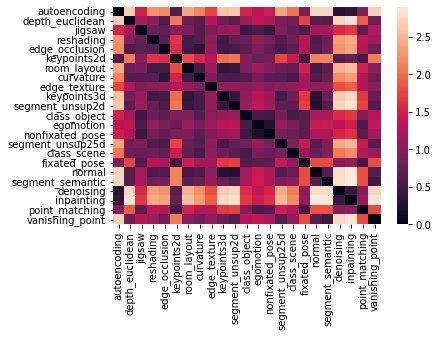

In [34]:
df = dfibc_m.unstack("layer")
rdm = pd.DataFrame(0, index=_models, columns=_models)

for c1, c2 in combinations(_models, 2):
    # sum of absoloute differences (easier, no correlation of correlated correlation coefficients)
    rdm.loc[c1, c2] = (df.loc[c1] - df.loc[c2]).abs().sum()
    rdm.loc[c2, c1] = (df.loc[c1] - df.loc[c2]).abs().sum()

# norming dissimilarity: sum_abs_diff / (num_layers * 2)
sns.heatmap(rdm, xticklabels=rdm.columns, yticklabels=rdm.index)
target_rdm = rdm

## version 2: correlation

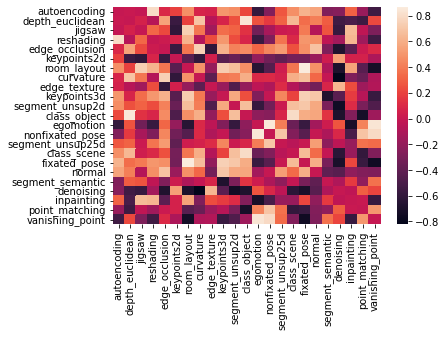

In [3]:
# TODO: add correlate correlations
df = dfibc_m.unstack("layer")
rdm = pd.DataFrame(0, index=_models, columns=_models)

for c1, c2 in combinations(_models, 2):
    rdm.loc[c1, c2] = pearsonr(df.loc[c1], df.loc[c2])[0]
    rdm.loc[c2, c1] = pearsonr(df.loc[c1], df.loc[c2])[0]

# norming dissimilarity: sum_abs_diff / (num_layers * 2)
sns.heatmap(rdm, xticklabels=rdm.columns, yticklabels=rdm.index)
target_rdm = rdm

# Predictor 1: semantic-2d-3d
Network grouping according to Radek paper <br>
[Finished predictor RDM ](#predictor-rdm-semantic-2d-3d)

In [ ]:
# add network classes to data

# integration
dfi = dfi.loc[NETS_ALL]
dfi["class"] = dfi.reset_index(level="model").model.apply(modelname2class).values
dfi = dfi.set_index("class", append=True)

dfi_m = dfi_m.loc[NETS_ALL]
dfi_m["class"] = dfi_m.reset_index(level="model").model.apply(modelname2class).values
dfi_m = dfi_m.set_index("class", append=True)


# ibcorr
dfibc = dfibc.loc[NETS_ALL]
dfibc["class"] = dfibc.reset_index(level="model").model.apply(modelname2class).values
dfibc = dfibc.set_index("class", append=True)

dfibc_m = dfibc_m.loc[NETS_ALL]
dfibc_m["class"] = dfibc_m.reset_index(level="model").model.apply(modelname2class).values
dfibc_m = dfibc_m.set_index("class", append=True)

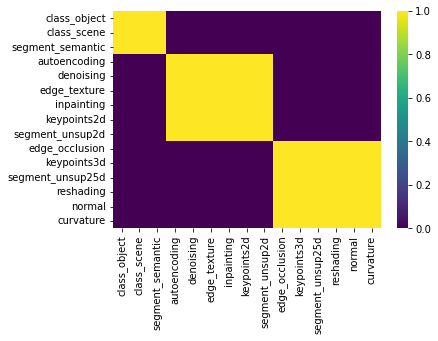

In [68]:
# model RDM
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap="viridis")

### variance partitioning

MODEL RDM as target,  steps as predictors <br>
shared variance between any of the models, subsequent added explained variance by each of the steps

In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
#    .unstack("layer")
)

In [ ]:
dfi_m_best

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .unstack("class")
)
dfi_m_classavg

In [ ]:
beauty_ratings["study1_places1_short.csv"].values.squeeze()

In [ ]:
dfi_m_classavg.loc[:,(slice(None),"2d")]

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## semantic, 2d, 3d along layers

### image activations

### raw integration amount


In [ ]:
# get beauty predictions for images from best predicting model in each layer for each class
bestnets = (
    dfibc_m.unstack("layer")
    .groupby("class")
    .aggregate(lambda c: c.idxmax()[0])
    .stack("layer")
    .rename({"ibcorr": "net"}, axis=1)
    .reset_index()
    .values.tolist()
)
dfi_m_best = (
    dfi_m.unstack("img")
    .reorder_levels(["class", "layer", "model"])
    .loc[bestnets, :]
    .droplevel("model")
    .stack("img")
#    .unstack("layer")
)

In [ ]:
dfi_m_best

In [ ]:
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

In [ ]:
# average beauty prediction (i.e. integration) for each image from each class
# since the ib-correlation is the spearman correlation. Just do OLS variance partitioning for now an then talk to daniel about it.
ibcorr_from_classmaxpool = (
    dfi_m_best.groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classmaxpool.plot()

ibcorr_from_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: pearsonr(-i, beauty_ratings["study1_places1_short.csv"])[0][0])
    .unstack("class")
)
ibcorr_from_classavg.plot()

In [ ]:
dfi_m_classavg = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .unstack("class")
)
dfi_m_classavg

In [ ]:
beauty_ratings["study1_places1_short.csv"].values.squeeze()

In [ ]:
dfi_m_classavg.loc[:,(slice(None),"2d")]

In [ ]:
r2_all = dfi_m_classavg.groupby(["layer"]).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
r2_semantic = r2_all - dfi_m_classavg.loc[:, (slice(None), ["2d", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

r2_2d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "3d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)


r2_3d = r2_all - dfi_m_classavg.loc[:, (slice(None), ["semantic", "2d"])].groupby(
    ["layer"]
).apply(
    lambda X: OLS(beauty_ratings["study1_places1_short.csv"].values.squeeze(), X.values)
    .fit()
    .rsquared
)

In [ ]:
plt.plot(r2_3d, label="3d")
plt.plot(r2_2d, label="2d")
plt.plot(r2_semantic, label="semantic")
plt.legend()

In [ ]:
# create linear model
# single study & layer
dataset = "places1"
layer_idx = 48

df_icr.loc[dataset, layer_idx]

OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## semantic, 2d, 3d along layers

### image activations

### raw integration amount


In [ ]:
# average integration of layers
df_int_netavg = df1.groupby("model").mean().transpose()
handles, labels = df_int_netavg.plot().get_legend_handles_labels()

# already order legend by classes
order = [labels.index(netname) for netname in NETS_ALL]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center right",
    bbox_to_anchor=(1.5, 0.5),
)

In [ ]:
# average integration, grouped by semantic-2d-3d
colors = (
    len(NETS_SEMANTIC) * ["green"]
    + len(NETS_2D) * ["purple"]
    + len(NETS_3D) * ["orange"]
)

for (netname, int_netavg), color in zip(df_int_netavg.iloc[:, order].items(), colors):
    if netname in NETS_SEMANTIC:
        alpha = 0.7
    else:
        alpha = 0.3
    plt.plot(int_netavg, label=netname, color=color, alpha=alpha)
    plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

## model RDM

In [ ]:
# create model RDM for semantiv-2D-3D nets integration
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap="viridis")

#### dev: single layer

In [ ]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL, "places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
sns.heatmap(rdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm > 0.142].fillna(0)
sns.heatmap(xdm, cmap="viridis")

In [ ]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap="viridis")

#### all layers

In [ ]:
dfi

In [ ]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:, "places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(
        pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0]
    )
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

In [ ]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color="cyan", s=100, marker="o")

### ibcorr differences

## inspect class average integration

In [ ]:
# per class best and worst prediction from individual nets
Y1 = dfibc_m.groupby(["layer", "class"]).agg([min, max])
Y2 = (
    dfi_m.groupby(["class", "layer", "img"])
    .mean()
    .groupby(["layer", "class"])
    .aggregate(lambda i: spearmanr(i, beauty_ratings["study1_places1_short.csv"])[0])
    .unstack("class")
)

In [ ]:
_, axes = plt.subplots(1,3, figsize=(12, 3), sharey=True)

modelclass = "semantic"
axes[0].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[0].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

modelclass = "2d"
axes[1].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[1].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

modelclass = "3d"
axes[2].fill_between(
    Y1.loc[(slice(None), modelclass), :].index.get_level_values("layer"),
    Y1.loc[(slice(None), modelclass), (slice(None), "min")].values.flat,
    Y1.loc[(slice(None), modelclass), (slice(None), "max")].values.flat,
)
axes[2].plot(-Y2.loc[:, (slice(None), modelclass)], c="red")

## predictor RDM (semantic-2d-3d)

Extend [model rdm](#model-rdm) to contain all models to use as predictor. Fill values for models not belonging to any class with zeros.

In [69]:
predictor_rdm_1 = pd.DataFrame(0, index=_models, columns=_models)
for c1, c2 in combinations_with_replacement(_models, 2):
    if c1 in model_rdm.index and c2 in model_rdm.index:
        predictor_rdm_1.loc[c1, c2] = 1 - model_rdm.loc[c1, c2]
        predictor_rdm_1.loc[c2, c1] = 1 - model_rdm.loc[c2, c1]
    else:
        predictor_rdm_1.loc[c1, c2] = 0
        predictor_rdm_1.loc[c2, c1] = 0

# Predictor 2:  integration profile across layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.

[Finished predictor RDM](#predictor-rdm-layer-layer-similarity-inside-networks)

TODO: this essentially the same thing as absoloute correlation differences alone ?
copy code for each models layerXlayer RDM
correlate correlations using daniels code

## version 1: layer X layer RDM for each network

In [ ]:
df1 = dfi.loc[(slice(None), slice(None), _scale, slice(None)), :].droplevel(["scale"])

In [ ]:
v1_rdms_p1, v1_rdms_p2, v1_rdms_oa = {}, {}, {}
for mo, df_mo in df1.groupby("model"):
    v1_rdms_p1[mo] = calculate_rdm(df_mo.loc[(slice(None), "places1"), :], "spearman")
    v1_rdms_p2[mo] = calculate_rdm(df_mo.loc[(slice(None), "places2"), :], "spearman")
    v1_rdms_oa[mo] = calculate_rdm(df_mo.loc[(slice(None), "oasis"), :], "spearman")

In [ ]:
PATH = os.path.join(PATH_RESULTS, "layer profile", "version 1")
with open(os.path.join(PATH, "rmds places1.pkl"), "wb") as f:
    pickle.dump(v1_rdms_p1, f)

with open(os.path.join(PATH, "rmds places2.pkl"), "wb") as f:
    pickle.dump(v1_rdms_p2, f)

with open(os.path.join(PATH, "rmds oasis.pkl"), "wb") as f:
    pickle.dump(v1_rdms_oa, f)

In [ ]:
PATH = os.path.join(PATH_RESULTS, "layer profile", "version 1")
with open(os.path.join(PATH, "rmds places1.pkl"), "rb") as f:
    v1_rdms_p1 = pickle.load(f)

with open(os.path.join(PATH, "rmds places2.pkl"), "rb") as f:
    v1_rdms_p2 = pickle.load(f)

with open(os.path.join(PATH, "rmds oasis.pkl"), "rb") as f:
    v1_rdms_oa = pickle.load(f)

## version 2: integration in best layer

ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

Interpretation: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

In [70]:
# best layer per model
bestlayers = dfibc_m.groupby("model").idxmax().ibcorr
df_bestpredicting_integration = (
    dfi_m.unstack("img").loc[bestlayers].droplevel("layer").T.droplevel(0)
)

## predictor RDM

In [ ]:
# version 1: correlate network RDMs
# RDMs into columns
# throw out zeros on diagonal to avoid skewing correlation (standard RSA procedure)
RDMs_places1 = pd.DataFrame(columns=_models)

for network_name, rdm in v1_rdms_p1.items():
    # mark diagonal values (all zeros)for removal
    np.fill_diagonal(rdm.values, np.nan)
    RDMs_places1.loc[:, network_name] = rdm.values.flatten()

# removed marked diagonal values
RDMs_places1 = RDMs_places1.dropna()

print("Should be (2353, 15)")
print(RDMs_places1.shape)

predictor_rdm_2 = calculate_rdm(RDMs_places1)

In [71]:
# version 2: only best layer
predictor_rdm_2 = calculate_rdm(df_bestpredicting_integration, "spearman")

# Predictor 3: spatial integration

"how"

"where" or alternatively "what",  which is the same because its spatial integration. Check for correlation between the what (represented by the integration ratings).

DONE IN SEPERATE NOTEBOOK

In [ ]:
# # import results
# with open(os.path.join(PATH_RESULTS, "spatial integration", "study1.pkl"), "rb") as f:
#     d1 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study2.pkl"), "rb") as f:
#     d2 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study3.pkl"), "rb") as f:
#     d3 = pickle.load(f)

# with open(os.path.join(PATH_RESULTS, "spatial integration", "study4.pkl"), "rb") as f:
#     d4 = pickle.load(f)


# rdm_study1 = calculate_rdm(flatten_concat(d1))
# rdm_study2 = calculate_rdm(flatten_concat(d2))
# rdm_study3 = calculate_rdm(flatten_concat(d3))
# rdm_study4 = calculate_rdm(flatten_concat(d4))

In [10]:
_study = "short presentation"
_scale = "scale4"


rdms = {}

for mo in MODEL_NAMES:
    rdm = pd.read_csv(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            _scale,
            _study,
            mo + ".csv",
        ),
        header=None,
    )
    rdm = rdm.iloc[1:, 1:].reset_index(drop=True).T.reset_index(drop=True).T

    rdms[mo] = rdm

In [29]:
df_rdms = flatten_concat(rdms).drop(np.arange(0, flatten_concat(rdms).shape[0], 251))

In [31]:
spatial_rdm = calculate_rdm(df_rdms)

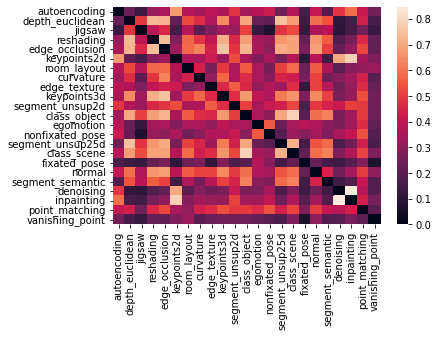

In [32]:
sns.heatmap(spatial_rdm, xticklabels=spatial_rdm.index, yticklabels=spatial_rdm.columns)

## integration is localized

In [ ]:
# visualize node score distribution

In [ ]:
# visualize within layer heatmaps

# exemplars

In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

## predctor RDM

In [33]:
predictor_rdm_3 = spatial_rdm

# GLM (Predictors, Target)
do for each study and each scale, to check if there is some consistency in which factors always comes out on top



In [ ]:
# TODO: make sure all matrices are either similarity or dissimilarity matrices.

In [ ]:
rdm = target_rdm
sns.heatmap(rdm, xticklabels=rdm.index, yticklabels=rdm.columns)

In [62]:
def rdm2predictor(rdm):
    p = np.triu(rdm.values, k=1).flat
    return p[np.nonzero(p)]    

In [63]:
p3 = rdm2predictor(predictor_rdm_3)

In [66]:
pearsonr(rdm2predictor(target_rdm), rdm2predictor(predictor_rdm_3))

(-0.42085092087462517, 2.7856778215475334e-12)

In [72]:
pearsonr(rdm2predictor(target_rdm), rdm2predictor(predictor_rdm_2))

(-0.004424186706386259, 0.9441754614387844)

In [73]:
pearsonr(rdm2predictor(target_rdm), rdm2predictor(predictor_rdm_1))

ValueError: x and y must have the same length.

In [ ]:
def correlate_rdms

In [ ]:
# predictor 1 alone
pearsonr(target_rdm.values.flatten(), predictor_rdm_1.values.flatten())

In [ ]:
pearsonr(target_rdm.values.flatten(), predictor_rdm_1.values.flatten())

In [ ]:
pearsonr(target_rdm.values.flatten(), predictor_rdm_1.values.flatten())

In [ ]:
# predictor 2 alone
pearsonr(target_rdm.values.flatten(), predictor_rdm_2.values.flatten())

In [ ]:
# target: scale16
pearsonr(target_rdm.values.flatten(), predictor_rdm_3.values.flatten())

In [ ]:
pearsonr(predictor_rdm_2.values.flatten(), predictor_rdm_3.values.flatten())

In [ ]:
# scale 4 selected models
pearsonr(target_rdm.values.flatten(), predictor_rdm_3.values.flatten())

In [ ]:
# variance partitioning between different predictors

In [ ]:
beauty_ratings["study1_places1_short.csv"]

In [ ]:
plt.scatter(dfi_m.loc[("edge_occlusion", "places1", "scale4",slice(None), 10)].rank(), beauty_ratings["study1_places1_short.csv"].rank())

In [ ]:
dfi_m.loc["edge_occlusion"].groupby(["dataset","scale", "layer"])

In [ ]:
beauty_ratings["study1_places1_short.csv"]

In [ ]:
plt.scatter(dfi_m.loc[("edge_occlusion", "places1", "scale4",slice(None), 10)].rank(), beauty_ratings["study1_places1_short.csv"].rank())

In [ ]:
dfi_m.loc["edge_occlusion"].groupby(["dataset","scale", "layer"])

In [ ]:
target_rdm.values.flatten().shape

In [ ]:
np.arange(0, len(MODEL_NAMES) ** 2, len(MODEL_NAMES) + 1)

In [ ]:
pearsonr(target_rdm.values.flatten(), predictor_rdm_2.values.flatten())

In [ ]:
plt.scatter(target_rdm.values.flatten(), predictor_rdm_2.values.flatten())

In [ ]:
df = (
    pd.DataFrame(
        [
            target_rdm.values.flatten(),
            predictor_rdm_1.values.flatten(),
            predictor_rdm_2.values.flatten(),
#            predictor_rdm_3.values.flatten(),
        ],
        index=["target", "P1", "P2"],
    )
    .drop(columns=np.arange(0, len(MODEL_NAMES) ** 2, len(MODEL_NAMES) + 1))
    .T
).rank()

In [ ]:
df.rank()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
predictors, target = df.loc[:,["P1","P2"]].values, df.target.values
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors)
results = model.fit()
r2_p1_p2 = results.rsquared

In [ ]:
predictors1, target = df.loc[:,["P1"]].values.squeeze(), df.target.values.squeeze()
#predictors1 = sm.add_constant(predictors1)
model = sm.OLS(target, predictors1)
results = model.fit()

r2_p2 = r2_p1_p2 - results.rsquared

In [ ]:
predictors2, target = df.loc[:,["P2"]].values.squeeze(), df.target.values.squeeze()
#predictors2 = sm.add_constant(predictors2)
model = sm.OLS(target, predictors2)
results = model.fit()

r2_p1 = r2_p1_p2 - results.rsquared

In [ ]:
y_pred = results.predict(predictors.squeeze())

In [ ]:
predictors.shape

In [ ]:
pearsonr(predictors1, target)

In [ ]:
plt.scatter(predictors1, target)

In [ ]:
predictors, target = df.loc[:,["P1"]].values, df.target.values
#predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors)
results = model.fit()
r2_p2 = r2_p1_p2 - results.rsquared

In [ ]:
r2_p1_p2

In [ ]:
r2_p1

In [ ]:
r2_p2

In [ ]:
r2_p2 / r2_p1_p2

In [ ]:
r2_p1/ r2_p1_p2

In [ ]:
predictors, target = df.loc[:,["P1","P2"]].values, df.target.values
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors)
results = model.fit()
r2_p1_p2 = results.rsquared

In [ ]:
predictors1, target = df.loc[:,["P1"]].values.squeeze(), df.target.values.squeeze()
#predictors1 = sm.add_constant(predictors1)
model = sm.OLS(target, predictors1)
results = model.fit()

r2_p2 = r2_p1_p2 - results.rsquared

In [ ]:
predictors2, target = df.loc[:,["P2"]].values.squeeze(), df.target.values.squeeze()
#predictors2 = sm.add_constant(predictors2)
model = sm.OLS(target, predictors2)
results = model.fit()

r2_p1 = r2_p1_p2 - results.rsquared

In [ ]:
y_pred = results.predict(predictors.squeeze())

In [ ]:
predictors.shape

In [ ]:
pearsonr(predictors1, target)

In [ ]:
plt.scatter(predictors1, target)

In [ ]:
predictors, target = df.loc[:,["P1"]].values, df.target.values
#predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors)
results = model.fit()
r2_p2 = r2_p1_p2 - results.rsquared

In [ ]:
r2_p1_p2

In [ ]:
r2_p1

In [ ]:
r2_p2

In [ ]:
r2_p2 / r2_p1_p2

In [ ]:
r2_p1/ r2_p1_p2

In [ ]:
pearsonr(df.target, df.P1)

In [ ]:
pearsonr(df.target, df.P2)

In [ ]:
pearsonr(df.target, df.P3)

In [ ]:
spearmanr(df.P1, df.P3)

In [ ]:
sns.heatmap(predictor_rdm_3)

In [ ]:
sns.histplot(predictor_rdm_3.values.flat)